In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFECV
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import ast

In [155]:
df = pd.read_csv("CleanData.csv", parse_dates=True)
df

,Ward Name,Street Name,Longitude,Latitude,Area (m²),Width (m),Length (m),Land Type,Legal Status,House Direction,Property Features,Price
0,Phường Hòa Minh,Thanh vinh 15,108.169500,16.065700,100.0,4.0,25.000000,4,6,5.0,"['Back Expansion', 'No Residential']",150000000
1,Phường Hòa Khánh Nam,Đường Hoàng Văn Thái,108.158270,16.053888,102.0,5.0,23.000000,4,6,8.0,['1 Part Residential'],165000000
2,Phường Hòa Khánh Nam,Đường Đà Sơn,108.150700,16.058900,150.0,10.0,15.000000,4,6,6.0,"['Back Expansion', '1 Part Residential', 'No R...",250000000
3,Phường Hòa Phát,Vũ lăng,108.172516,16.028736,100.0,5.0,20.000000,4,5,6.0,"['No Residential', 'Back Expansion', '1 Part R...",250000000
4,Phường Hòa Khánh Bắc,Âu cơ,108.136940,16.077059,100.0,5.0,20.000000,4,5,4.0,"['No Residential', 'Back Expansion']",250000000
...,...,...,...,...,...,...,...,...,...,...,...,...
3218,Phường Hòa Cường Nam,Đường Trần Đăng Ninh,108.229570,16.031054,309.0,10.0,25.000000,1,1,1.0,['Frontage'],16820000000
3219,Phường Hòa Minh,Phường Hòa Minh,108.169550,16.065733,309.0,5.0,40.470000,1,1,4.0,['1 Part Residential'],16820000000
3220,Phường Khuê Trung,Đường Đỗ Thúc Tịnh,108.211190,16.022854,81.0,4.5,20.000000,1,1,7.0,"['Frontage', 'Back Expansion']",16820000000
3221,Phường Hoà Quý,phạm đình bân,108.233420,15.982958,100.0,5.0,20.000000,2,1,5.0,['No Residential'],16820000000


In [156]:
def convert_to_list(value):
    if isinstance(value, str): 
        try:
            return ast.literal_eval(value)  
        except:
            return [value.strip()]  
    elif isinstance(value, list):
        return value 
    else:
        return [] 

### One-hot encoding 

In [157]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded_columns = encoder.fit_transform(df[["Ward Name", "Street Name"]])
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(["Ward Name", "Street Name"]))

df_final = df.drop(columns=["Ward Name", "Street Name"]).join(encoded_df)

df_final.head()


,Longitude,Latitude,Area (m²),Width (m),Length (m),Land Type,Legal Status,House Direction,Property Features,Price,...,Street Name_Đỗ Chính,Street Name_Đỗ Phát,Street Name_đinh gia trinh,Street Name_điện ngọc,Street Name_đường 1 thôn Phước Hưng,Street Name_đường 5,Street Name_đường 7m5 - Khu E Kim Long,Street Name_đường golden Hills,Street Name_đường khue đông,Street Name_đường số 5
0,108.169500,16.065700,100.0,4.0,25.0,4,6,5.0,"['Back Expansion', 'No Residential']",150000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,108.158270,16.053888,102.0,5.0,23.0,4,6,8.0,['1 Part Residential'],165000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,108.150700,16.058900,150.0,10.0,15.0,4,6,6.0,"['Back Expansion', '1 Part Residential', 'No R...",250000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,108.172516,16.028736,100.0,5.0,20.0,4,5,6.0,"['No Residential', 'Back Expansion', '1 Part R...",250000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,108.136940,16.077059,100.0,5.0,20.0,4,5,4.0,"['No Residential', 'Back Expansion']",250000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
df["Property Features"] = df["Property Features"].apply(convert_to_list)
mlb = MultiLabelBinarizer()

features_encoded = mlb.fit_transform(df["Property Features"])

df_features = pd.DataFrame(features_encoded, columns=mlb.classes_)
df = df.drop(columns=["Property Features"]).reset_index(drop=True)
df_final = df_final.drop(columns=["Property Features"]).reset_index(drop=True)
df = pd.concat([df_final, df_features], axis=1)


df.head()

,Longitude,Latitude,Area (m²),Width (m),Length (m),Land Type,Legal Status,House Direction,Price,Ward Name_Phường An Hải Bắc,...,Street Name_đường 7m5 - Khu E Kim Long,Street Name_đường golden Hills,Street Name_đường khue đông,Street Name_đường số 5,1 Part Residential,All Residential,Back Expansion,Car Alley,Frontage,No Residential
0,108.169500,16.065700,100.0,4.0,25.0,4,6,5.0,150000000,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,1
1,108.158270,16.053888,102.0,5.0,23.0,4,6,8.0,165000000,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,108.150700,16.058900,150.0,10.0,15.0,4,6,6.0,250000000,0.0,...,0.0,0.0,0.0,0.0,1,0,1,0,0,1
3,108.172516,16.028736,100.0,5.0,20.0,4,5,6.0,250000000,0.0,...,0.0,0.0,0.0,0.0,1,0,1,0,0,1
4,108.136940,16.077059,100.0,5.0,20.0,4,5,4.0,250000000,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,1


## Feature Transformation

### Normalize by taking the inverse method

In [160]:
columns_to_inverse = ["Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)"]
df_inverse_transformed = df.copy() 
df_inverse_transformed[columns_to_inverse] = 1 / df_inverse_transformed[columns_to_inverse]
df_inverse_transformed[columns_to_inverse].head()

,Longitude,Latitude,Area (m²),Width (m),Length (m)
0,0.009245,0.062244,0.010000,0.25,0.040000
1,0.009246,0.062290,0.009804,0.20,0.043478
2,0.009246,0.062271,0.006667,0.10,0.066667
3,0.009244,0.062388,0.010000,0.20,0.050000
4,0.009248,0.062200,0.010000,0.20,0.050000


### Normalize using Arcsine method

In [161]:
columns_to_asinh = ["Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)"]
df_asinh_transformed = df.copy()
df_asinh_transformed[columns_to_asinh] = np.arcsinh(df_asinh_transformed[columns_to_asinh])
df_asinh_transformed[columns_to_asinh].head()

,Longitude,Latitude,Area (m²),Width (m),Length (m)
0,5.376868,3.470801,5.298342,2.094713,3.912423
1,5.376764,3.470067,5.318144,2.312438,3.829114
2,5.376694,3.470378,5.703794,2.998223,3.402307
3,5.376896,3.468502,5.298342,2.312438,3.689504
4,5.376567,3.471506,5.298342,2.312438,3.689504


### Normalization using Z-score method

In [162]:
columns_to_zScore = ["Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)"]
std_scaler_zScore = StandardScaler()
df_std_scaled_zScore = std_scaler_zScore.fit_transform(df[columns_to_zScore])
df_std_scaled_zScore = pd.DataFrame(df_std_scaled_zScore, columns=columns_to_zScore)
df_std_scaled_zScore[columns_to_zScore].head()

,Longitude,Latitude,Area (m²),Width (m),Length (m)
0,-0.656839,0.866929,-0.405024,-1.078667,0.736588
1,-0.875574,0.574112,-0.373798,-0.513118,0.407946
2,-1.023021,0.698358,0.375624,2.314626,-0.906622
3,-0.598094,-0.049402,-0.405024,-0.513118,-0.085017
4,-1.291034,1.148517,-0.405024,-0.513118,-0.085017


### Normalize using Logarithmic method

In [163]:
columns_to_log = ["Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)"]
df_log_transformed = df.copy()
df_log_transformed = df[columns_to_log].apply(np.log1p)
df_log_transformed = pd.DataFrame(df_log_transformed, columns=columns_to_log)
df_log_transformed[columns_to_log].head()

,Longitude,Latitude,Area (m²),Width (m),Length (m)
0,4.692902,2.837071,4.615121,1.609438,3.258097
1,4.692799,2.836378,4.634729,1.791759,3.178054
2,4.692729,2.836672,5.017280,2.397895,2.772589
3,4.692929,2.834902,4.615121,1.791759,3.044522
4,4.692603,2.837736,4.615121,1.791759,3.044522


### Normalize using square root method

In [164]:
columns_to_sqrt = ["Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)"]
df_sqrt_transformed = df.copy()
df_sqrt_transformed = df[columns_to_sqrt].apply(np.sqrt)
df_sqrt_transformed = pd.DataFrame(df_sqrt_transformed, columns=columns_to_sqrt)
df_sqrt_transformed[columns_to_sqrt].head()

,Longitude,Latitude,Area (m²),Width (m),Length (m)
0,10.400457,4.008204,10.000000,2.000000,5.000000
1,10.399917,4.006730,10.099505,2.236068,4.795832
2,10.399553,4.007356,12.247449,3.162278,3.872983
3,10.400602,4.003590,10.000000,2.236068,4.472136
4,10.398891,4.009621,10.000000,2.236068,4.472136


### Data verification

*Histogram comparing the variable Area (m²) before and after normalization*

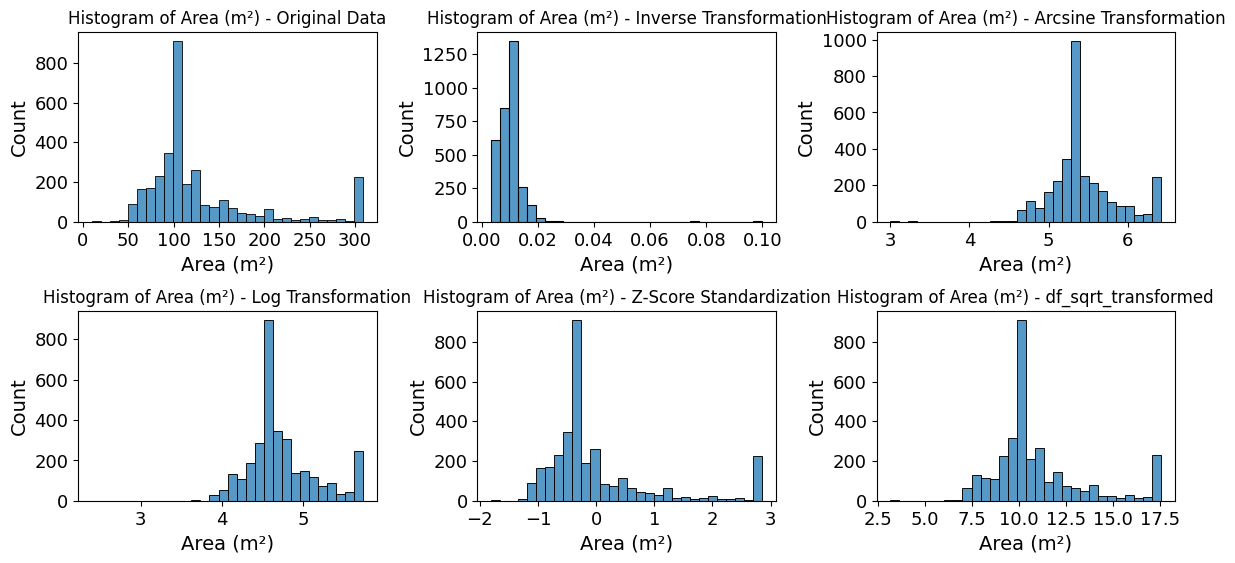

In [165]:
dfs = [df, df_inverse_transformed, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Inverse Transformation", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']
plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    sns.histplot(data=data['Area (m²)'], bins=30)
    plt.ylabel('Count', fontsize = 14)
    plt.xlabel('Area (m²)', fontsize = 14)
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.title(f'Histogram of Area (m²) - {method}')
    plt.tight_layout()

plt.show()

*Use probability graph to verify whether the transformed data follows the normal distribution*

- Comparison of the distribution of the *Area (m²)* feature when applying normalization methods

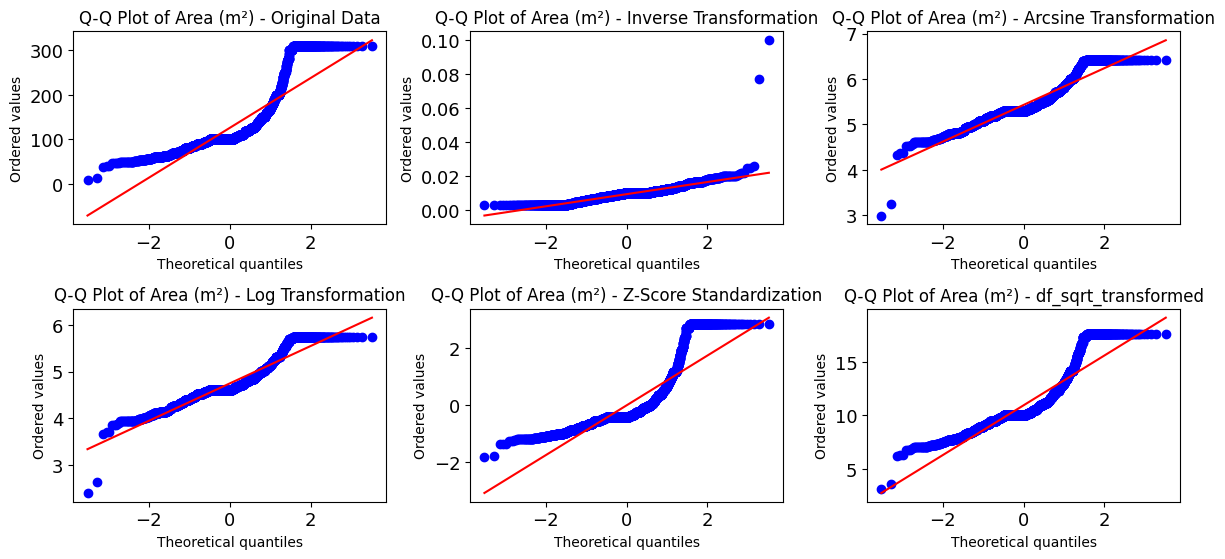

In [166]:
dfs = [df, df_inverse_transformed, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Inverse Transformation", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Area (m²)'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Area (m²) - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Width (m)* feature when applying normalization methods

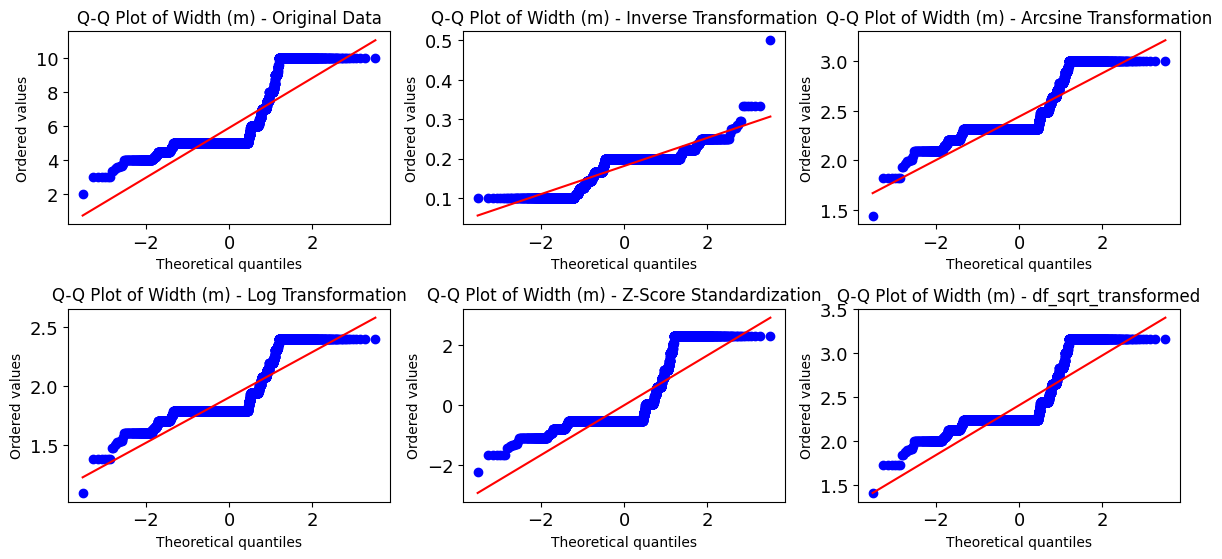

In [167]:
dfs = [df, df_inverse_transformed, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Inverse Transformation", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Width (m)'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Width (m) - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Longitude* feature when applying normalization methods

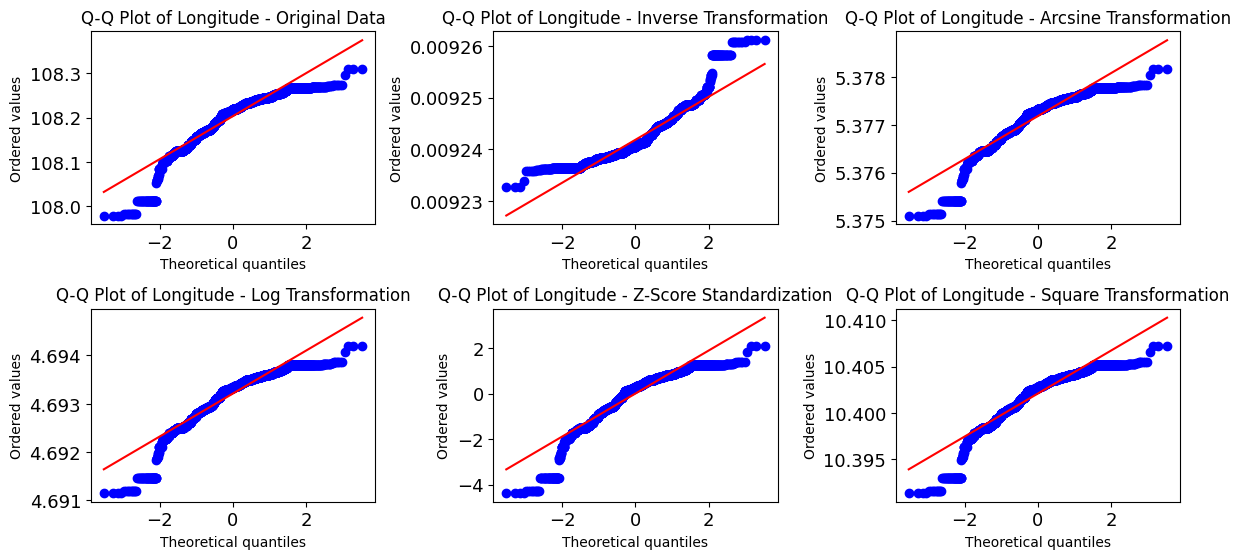

In [168]:
dfs = [df, df_inverse_transformed, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Inverse Transformation", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Longitude'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Longitude - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Latitude* feature when applying normalization methods

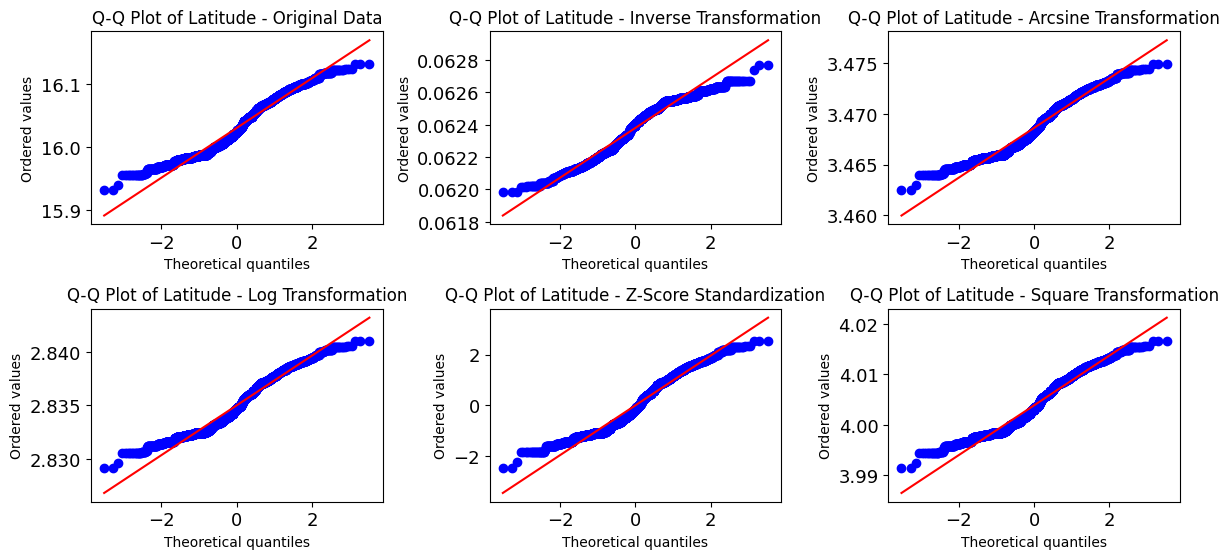

In [169]:
dfs = [df, df_inverse_transformed, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Inverse Transformation", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Latitude'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Latitude - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

*The characteristic that follows the most normal distribution is standardized by the square root method.*

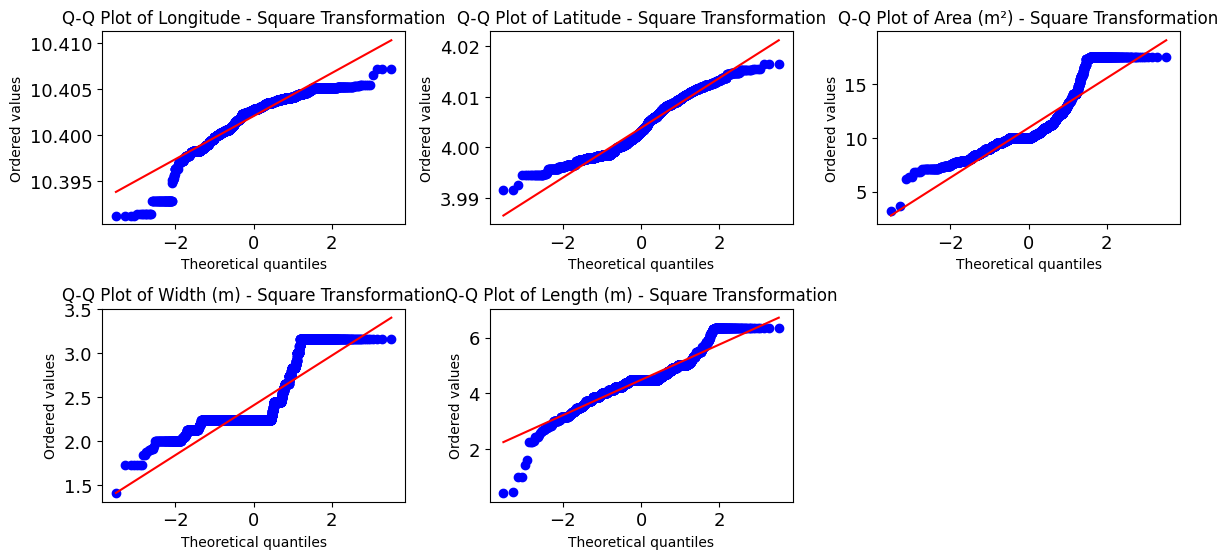

In [170]:
cols = ["Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i) 
    stats.probplot(df_sqrt_transformed[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col} - Square Transformation")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Length (m)* when applying standardized methods

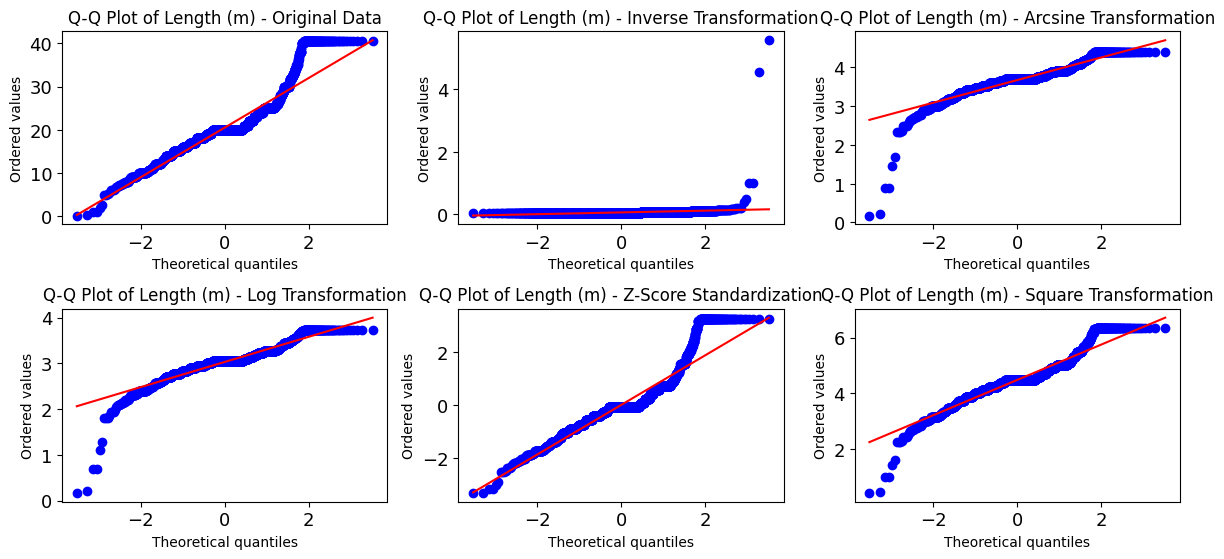

In [171]:
dfs = [df, df_inverse_transformed, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Inverse Transformation", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Length (m)"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Length (m) - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

=> Select Z-Score normalization method for feature *Length (m)* and square root method for features *Longitude", Latitude, Area (m²), Width (m)*

In [172]:
df_final = df.copy()

df_final["Length (m)"] = df_std_scaled_zScore["Length (m)"]

columns_sqrt = ["Longitude", "Latitude", "Area (m²)", "Width (m)"]
df_final[columns_sqrt] = df_sqrt_transformed[columns_sqrt]

df_final.head()


,Longitude,Latitude,Area (m²),Width (m),Length (m),Land Type,Legal Status,House Direction,Price,Ward Name_Phường An Hải Bắc,...,Street Name_đường 7m5 - Khu E Kim Long,Street Name_đường golden Hills,Street Name_đường khue đông,Street Name_đường số 5,1 Part Residential,All Residential,Back Expansion,Car Alley,Frontage,No Residential
0,10.400457,4.008204,10.000000,2.000000,0.736588,4,6,5.0,150000000,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,1
1,10.399917,4.006730,10.099505,2.236068,0.407946,4,6,8.0,165000000,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,10.399553,4.007356,12.247449,3.162278,-0.906622,4,6,6.0,250000000,0.0,...,0.0,0.0,0.0,0.0,1,0,1,0,0,1
3,10.400602,4.003590,10.000000,2.236068,-0.085017,4,5,6.0,250000000,0.0,...,0.0,0.0,0.0,0.0,1,0,1,0,0,1
4,10.398891,4.009621,10.000000,2.236068,-0.085017,4,5,4.0,250000000,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,1


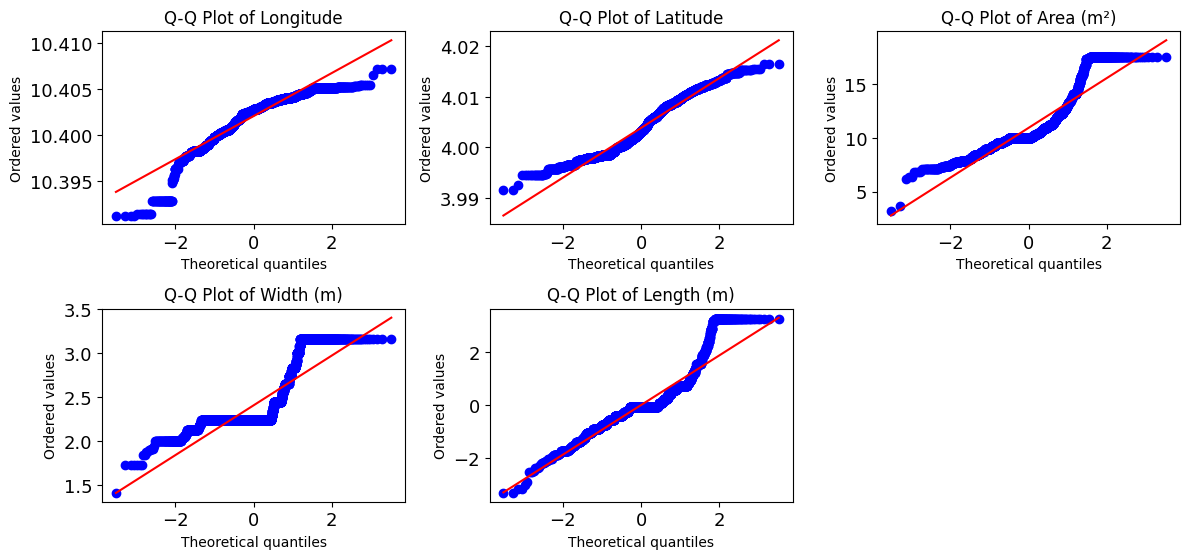

In [173]:
cols = ["Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i) 
    stats.probplot(df_final[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

In [174]:
df_final.to_csv('TransformedData.csv', index=False)
print("Đã xuất DataFrame ra file CSV.")

Đã xuất DataFrame ra file CSV.


## Feature selection

In [175]:
df = pd.read_csv("TransformedData.csv", parse_dates=True)
df

,Longitude,Latitude,Area (m²),Width (m),Length (m),Land Type,Legal Status,House Direction,Price,Ward Name_Phường An Hải Bắc,...,Street Name_đường 7m5 - Khu E Kim Long,Street Name_đường golden Hills,Street Name_đường khue đông,Street Name_đường số 5,1 Part Residential,All Residential,Back Expansion,Car Alley,Frontage,No Residential
0,10.400457,4.008204,10.000000,2.000000,0.736588,4,6,5.0,150000000,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,1
1,10.399917,4.006730,10.099505,2.236068,0.407946,4,6,8.0,165000000,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,10.399553,4.007356,12.247449,3.162278,-0.906622,4,6,6.0,250000000,0.0,...,0.0,0.0,0.0,0.0,1,0,1,0,0,1
3,10.400602,4.003590,10.000000,2.236068,-0.085017,4,5,6.0,250000000,0.0,...,0.0,0.0,0.0,0.0,1,0,1,0,0,1
4,10.398891,4.009621,10.000000,2.236068,-0.085017,4,5,4.0,250000000,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3218,10.403344,4.003880,17.578396,3.162278,0.736588,1,1,1.0,16820000000,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0
3219,10.400459,4.008208,17.578396,2.236068,3.278634,1,1,4.0,16820000000,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3220,10.402461,4.002856,9.000000,2.121320,-0.085017,1,1,7.0,16820000000,0.0,...,0.0,0.0,0.0,0.0,0,0,1,0,1,0
3221,10.403529,3.997869,10.000000,2.236068,-0.085017,2,1,5.0,16820000000,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1


In [176]:
features = ['Longitude', 'Latitude', 'Area (m²)', 'Width (m)', 'Length (m)', 'Land Type', 'House Direction', 'Legal Status']
X = df[features]
y = df["Price"]

### Data Visualization

#### Relationship of Target Variable to Input Variables

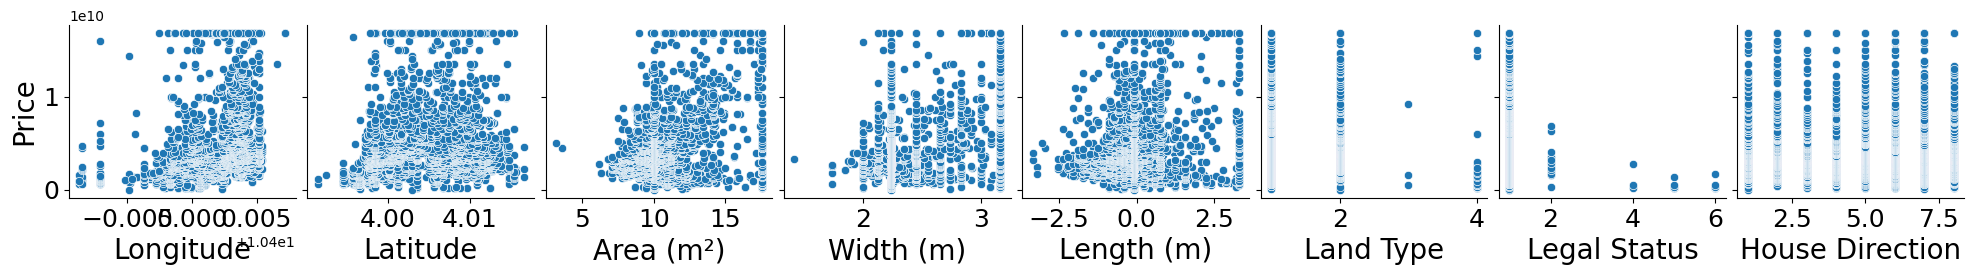

In [177]:
features = ['Longitude', 'Latitude', 'Area (m²)', 'Width (m)', 'Length (m)', 'Land Type',	'Legal Status', 'House Direction']

pairplt_trans = sns.pairplot(df, x_vars=features, y_vars=['Price'])

for ax in pairplt_trans.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18) 

plt.show()

#### Comment
 - In the graph `Price & Area (m²)`, the points have a slight upward trend in distribution (positive correlation). 
 - The remaining features have a clear scatter distribution. 
 - There are some features that are concentrated at certain points
#### Conclusion
 - Weak correlation: Only `Price` and `Area (m²)` have a slight increasing trend, indicating that there may be a weak positive correlation.
 - Other variables have no clear correlation: `Longitude, Latitude, Width, Length` have no specific pattern, and are distributed quite randomly.
 - There are clusters of data at some points: Some variables have concentrated points, possibly because the data is limited to some ranges or is influenced by other factors such as location, property type.

#### Using HeatMap to Represent Correlation of Input Variable Pairs

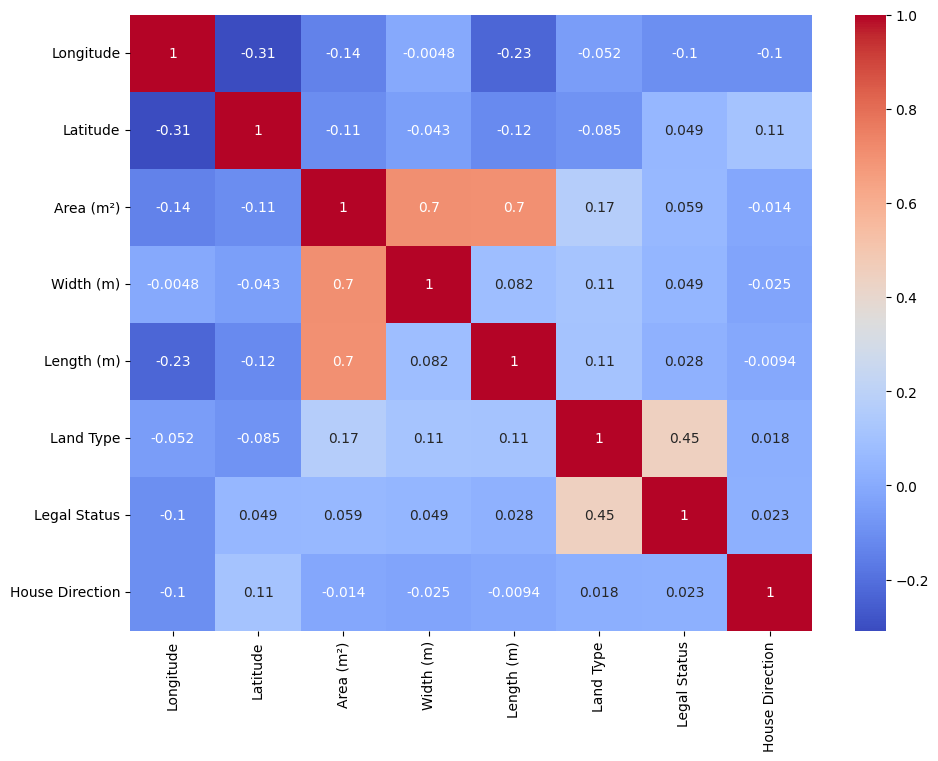

In [178]:
cols_to_include = ['Longitude', 'Latitude', 'Area (m²)', 'Width (m)', 'Length (m)', 'Land Type',	'Legal Status', 'House Direction']
plt.figure(figsize=(11, 8))
sns.heatmap(df[cols_to_include].corr(), annot=True, cmap='coolwarm')

plt.show()

#### Using ScatterPlot to represent the relationship between 2 variables `Width (m)` and `Area (m²)`

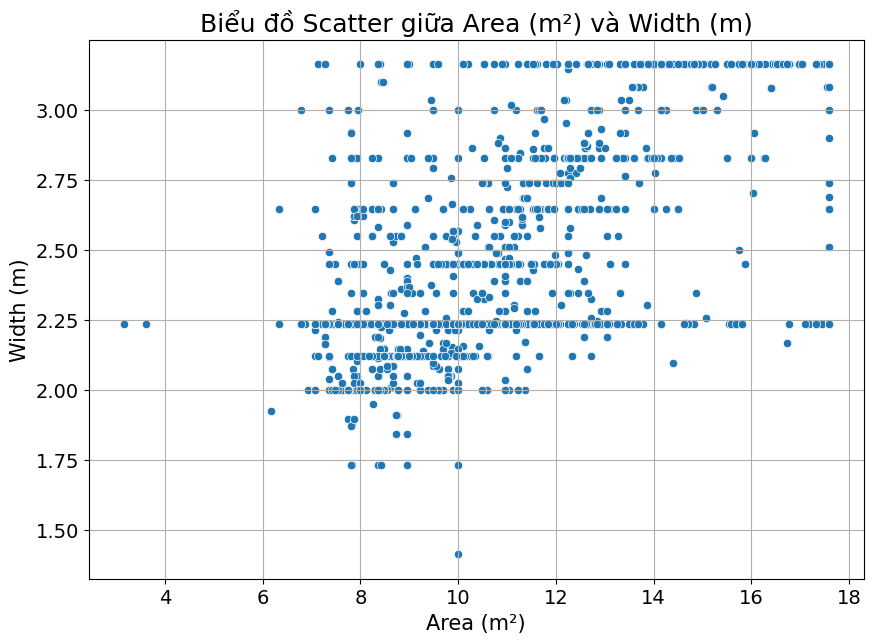

In [179]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Area (m²)', y='Width (m)', data=df)
plt.title('Biểu đồ Scatter giữa Area (m²) và Width (m)', fontsize=18)
plt.xlabel('Area (m²)', fontsize=15)
plt.ylabel('Width (m)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()

#### Using ScatterPlot to represent the relationship between 2 variables `Length (m)` and `Area (m²)`

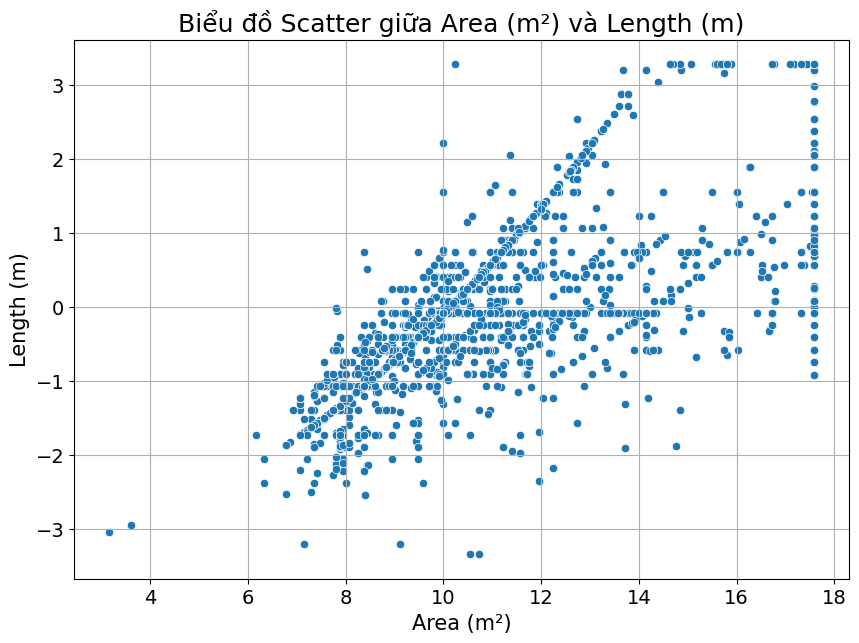

In [180]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Area (m²)', y='Length (m)', data=df)
plt.title('Biểu đồ Scatter giữa Area (m²) và Length (m)', fontsize=18)
plt.xlabel('Area (m²)', fontsize=15)
plt.ylabel('Length (m)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()

#### Comments
 - Based on the two graphs above, we see that the input variables are almost independent and do not depend on each other. Only the variables Length and Area have the most obvious correlation with each other (>0.7) according to Heatmap. 
 - At the same time, through ScatterPlot, the points tend to be distributed in an upward straight line (positive correlation).
#### Conclusion
It can be said that the higher the Length value, the larger the Area value and vice versa. 
In the future, one of these two variables can be eliminated to reduce overfitting of the model

### Statistical methods
#### Univariate feature selection

In [181]:
selector_best = SelectKBest(score_func=mutual_info_regression, k=8)
X_kbest = selector_best.fit_transform(X, y)
selected_features = X.columns[selector_best.get_support()]
scores = selector_best.scores_

sorted_indices = np.argsort(scores)[::-1]

print("Selected features in order from best to worst:")
for index in sorted_indices:
  print(f"{selected_features[index]}: {scores[index]}")

Selected features in order from best to worst:
Longitude: 0.9319142175514941
Latitude: 0.8450611006942577
Area (m²): 0.7793456797122125
Length (m): 0.3881567176801939
Width (m): 0.30130965873733384
House Direction: 0.08487810671794938
Land Type: 0.06995452829786775
Legal Status: 0.03788402689779602


##### Conclusion:
For statistical methods, by using the application of univariate statistical testing, it is possible to arrange the order of variables from most important to least important. The Longitude variable is considered the most important variable among the input variables.


### Recursive feature elimination
#### Recursive feature elimination with cross-validation

In [182]:
min_features_to_select = 1
regressor = LinearRegression()

cv = KFold(n_splits=5)

rfecv = RFECV(
    estimator=regressor,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")
selected_features = X.columns[rfecv.support_]
print("Selected features:", selected_features)

Optimal number of features: 7
Selected features: Index(['Longitude', 'Latitude', 'Area (m²)', 'Width (m)', 'Length (m)',
       'Land Type', 'Legal Status'],
      dtype='object')


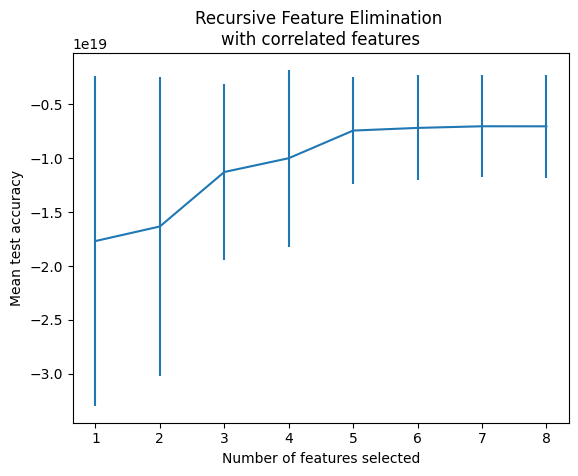

In [183]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Conclusion

#### Comments on the results

- Optimal number of features: 7. The results show that the model performs best when keeping all 7 features. That is, removing any of these 7 columns causes the model to degrade (higher MSE).

- Selected features: `Longitude`, `Latitude`, `Area (m²)`, `Width (m)`, `Length (m)`, `Land Type`, `House Direction`. These are the 7 selected features. If X initially has exactly these 7 columns, it proves that all are important for prediction. If X has more columns, then the results show that these 7 columns are the best according to the neg_mean_squared_error criterion.

#### From the graph

- The curve (mean_test_score) shows how the model improves or deteriorates when the number of features is gradually reduced.
- The error bars (yerr) show the variation over the cross-validation runs.

- The highest point of the curve corresponds to the selection of 7 features.

#### Conclusion
- The LinearRegression model with the above 7 features is the most optimal according to the MSE evaluation during the recursive feature elimination (RFECV) process.

- If your goal is to optimize the number of features (feature selection), the results show that keeping 7 features is the best performance.

- In case you expect to remove some features while maintaining the same performance, this result shows that the model probably needs all 7 columns to perform well.